==================== simulation results ====================
max thrust = 455.216432653737 (N)
max chamber pressure = 2.4561030883189545 (MPa)
burning time = 2.0468227424749164 (s)
total inpulse = 800.4148582048074 (Ns)
average thrust = 392.6810785702211 (N)
oxidizer consumption = 0.40112666814623915 (kg)
fuel consumption = 0.040740317659976495 (kg)
Isp = 184.84066054874265 (s)
final fuel port diameter = 34.84261755672539 (mm)
sliver ratio = 54.760000427564606 (%)
====================== execution time ======================
execution time = 2.0658922919997167 (s)


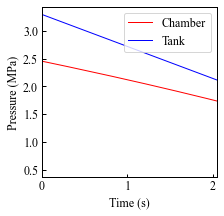

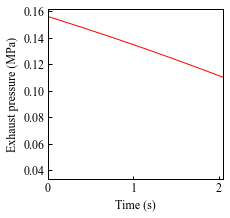

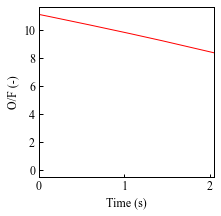

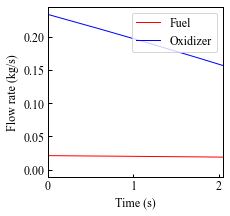

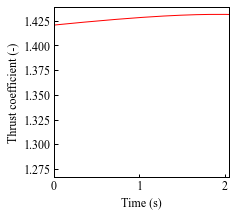

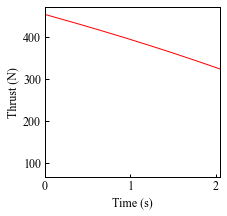

In [29]:
#! /usr/bin/env python
# coding: utf-8

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize_scalar, minimize
import time
 
start_time = time.perf_counter()

plt.rcParams['font.family'] ='Times new roman'#使用するフォント
plt.rcParams['xtick.direction'] = 'in'#x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in'#y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.0#x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.0#y軸主目盛り線の線幅
plt.rcParams['font.size'] = 12 #フォントの大きさ
plt.rcParams['axes.linewidth'] = 1.0# 軸の線幅edge linewidth。囲みの太さ

# 入力値
P_t_i = 3.3 		# 初期タンク圧 (MPa)
P_t_f = 2.0 		# 最終タンク圧 (MPa)
t_b_d = 2.24 		# 燃焼予定時間 (s)
V_ox_i = 450 		# 酸化剤充填量 (cc)
rho_ox = 895.67 	# 酸化剤密度 (kg/m^3)
gamma_ox = 0 		# 酸化剤ガス比熱比 (-)
D_o = 3.4 			# オリフィス径 (mm)
C_d = 0.665 		# 流量計数 (-)
rho_f = 910 		# 燃料密度 (kg/m^3)
L_f = 300 			# 燃料軸長 (mm)
D_f_i = 32 			# 初期ポート径 (mm)
D_f_out = 38 		# 燃料外径 (mm)
N_port = 1 			# ポート数 (個)
a = 1.04e-4 		# 酸化剤流速係数 (m^3/kg)
n = 0.352 			# 酸化剤流速指数 (-)
eta_c_star = 0.85 	# C*効率 (-)
P_o = 0.1013 		# 背圧 (MPa)
D_t_i = 13.0 		# 初期スロート径 (mm)
D_e = 22.2 			# ノズル出口径 (mm)
alpha = 15 			# ノズル開口半長角 (deg)
r_dot_n = 0			# エロージョン速度 (mm/s)

# シミュレーション設定
simulation_time = 3							# シミュレーション時間 (s)
Ts = 10e-3									# サンプリング周期 (s)
t = np.linspace(0, simulation_time, int(simulation_time / Ts))
m_ox = np.zeros([len(t), 1])				# 酸化剤消費量 (Kg)
P_t = np.zeros([len(t), 1])					# タンク圧 (MPa)
P_c = np.zeros([len(t), 1])					# 燃焼室圧 (MPa)
m_dot_ox = np.zeros([len(t), 1])			# 酸化剤流量 (kg/s)
m_f = np.zeros([len(t), 1])					# 燃料消費量 (kg)
D_f = np.zeros([len(t), 1])					# ポート径 (mm)
G_ox = np.zeros([len(t), 1])				# 酸化剤流速 (kg/m^2s)
r_dot = np.zeros([len(t), 1])				# 燃料後退速度 (mm/s)
m_dot_f = np.zeros([len(t), 1])				# 燃料流量 (kg/s)
o_f = np.zeros([len(t), 1])					# OF比 (-)
eta_c_star_c_star = np.zeros([len(t), 1])	# 特性排気速度 (m/s)
gamma = np.zeros([len(t), 1])				# 比熱比 (-)
D_t = np.zeros([len(t), 1])					# スロート径 (mm)
P_e = np.zeros([len(t), 1])					# ノズル出口圧 (MPa)
C_f = np.zeros([len(t), 1])					# 推力係数 (-)
F_t = np.zeros([len(t), 1])					# 推力 (N)
I_t = np.zeros([len(t), 1])					# 力積 (Ns)
# P_c_d = np.zeros([len(t), 1])				# 燃焼室圧 (MPa)
# diff_P_c_d = np.zeros([len(t), 1])		# 燃焼室圧誤差 (%)
epsilon_d = np.zeros([len(t), 1])			# 開口比 (-)
# diff_epsilon_d = np.zeros([len(t), 1])	# 開口比誤差 (%)

# C*csvと比熱比csvを読み込み
df_c_star = pd.read_csv('cstar.csv', header=0, index_col=0, dtype=np.float64)
df_gamma = pd.read_csv('gamma.csv', header=0, index_col=0, dtype=np.float64)

# シミュレーション (1ステップ目)
def func1(x):
	xP_c, P_c_d = x[0], x[1]
	return abs((xP_c - P_c_d) / P_c_d * 100)

def cons1(x):
	xP_c, P_c_d = x[0], x[1]
	m_ox[0, 0] = 0
	P_t[0, 0] = (P_t_f - P_t_i) * 0 / t_b_d + P_t_i
	if P_t[0, 0] > xP_c:
		diff_P = P_t[0, 0] - xP_c
	else:
		diff_P = 1e-6
	if m_ox[0, 0] <= V_ox_i * rho_ox * 1e-6:
		m_dot_ox[0, 0] = C_d * (math.pi / 4 * (D_o * 1e-3)**2) * math.sqrt(2 * rho_ox * diff_P * 1e6)
	else:
		m_dot_ox[0, 0] = 0
	m_f[0, 0] = 0
	D_f[0, 0] = math.sqrt(4 * m_f[0, 0] / (N_port * math.pi * rho_f * L_f * 1e-3) + (D_f_i * 1e-3)**2) * 1e3
	G_ox[0, 0] = 4 * m_dot_ox[0, 0] / (N_port * math.pi *(D_f[0, 0] * 1e-3)**2)
	r_dot[0, 0] = a * G_ox[0, 0]**n * 1e3
	m_dot_f[0, 0] = L_f * 1e-3 * math.pi * D_f[0, 0] * 1e-3 * rho_f * r_dot[0, 0] * 1e-3 * N_port
	o_f[0, 0] = m_dot_ox[0, 0] / m_dot_f[0, 0]
	if np.round(o_f[0, 0], 1) <= 0.5:
		index_o_f = 0.5
	elif np.round(o_f[0, 0], 1) >= 19.5:
		index_o_f = 19.5
	else:
		index_o_f = np.round(o_f[0, 0], 1)
	if np.round(xP_c, 1) <= 0.5:
		index_P_c = 0.5
	elif np.round(xP_c, 1) >= 4.9:
		index_P_c = 4.9
	else:
		index_P_c = np.round(xP_c, 1)
	eta_c_star_c_star[0, 0] = eta_c_star * (df_c_star.at[index_o_f, str(index_P_c)] \
		+ (o_f[0, 0] - index_o_f) / 0.1 * (df_c_star.at[np.round(index_o_f + 0.1, 1), str(index_P_c)] - df_c_star.at[index_o_f, str(index_P_c)]) \
		+ (xP_c - index_P_c) / 0.1 * (df_c_star.at[index_o_f, str(np.round(index_P_c + 0.1, 1))] - df_c_star.at[index_o_f, str(index_P_c)]))
	gamma[0, 0] = df_gamma.at[index_o_f, str(index_P_c)] \
		+ (o_f[0, 0] - index_o_f) / 0.1 * (df_gamma.at[np.round(index_o_f + 0.1, 1), str(index_P_c)] - df_gamma.at[index_o_f, str(index_P_c)]) \
		+ (xP_c - index_P_c) / 0.1 * (df_gamma.at[index_o_f, str(np.round(index_P_c + 0.1, 1))] - df_gamma.at[index_o_f, str(index_P_c)])
	D_t[0, 0] = D_t_i
	P_e[0, 0] = 0.1
	v = P_c_d - (4 * eta_c_star_c_star[0, 0] * (m_dot_ox[0, 0] + m_dot_f[0, 0]) / (math.pi * D_t[0, 0]**2))
	return v

cons = (
    {'type': 'eq', 'fun': cons1}
)

bounds = [[0.5, 5], [0.5, 5]]

x_i = [0.5, 0.5]

result = minimize(func1, x0=x_i, constraints=cons, bounds=bounds, method="SLSQP")
P_c[0, 0] = result.x[0]

def func2(xP_e):
	epsilon_d[0, 0] = ((2 / (gamma[0, 0] + 1))**(1 / (gamma[0, 0] - 1))) * ((P_c[0, 0] / xP_e)**(1 / gamma[0, 0])) / math.sqrt((gamma[0, 0] + 1) / (gamma[0, 0] - 1) * (1 - (xP_e / P_c[0, 0])**((gamma[0, 0] - 1) / gamma[0, 0])))
	v = abs((epsilon_d[0, 0] - (D_e**2 / D_t_i**2)) / (D_e**2 / D_t_i**2) * 100) # 目的関数
	return v

result = minimize_scalar(func2, method='bounded', bounds=(0, 0.2))
P_e[0, 0] = result.x
C_f[0, 0] = math.sqrt(2 * gamma[0, 0]**2 / (gamma[0, 0] - 1) * ((2 / (gamma[0, 0] + 1))**((gamma[0, 0] + 1) / (gamma[0, 0] - 1))) * (1 - (P_e[0, 0] / P_c[0, 0])**((gamma[0, 0] - 1) / gamma[0, 0]))) \
	+ ((P_e[0, 0] - P_o) / P_c[0, 0]) * ((D_e**2) / D_t_i**2)
F_t[0, 0] = ((1 + math.cos(math.radians(alpha))) / 2) * C_f[0, 0] * P_c[0, 0] * (math.pi * D_t_i**2 / 4)
I_t[0, 0] = 0

# シミュレーション (2ステップ目)
def func1(x):
	xP_c, P_c_d = x[0], x[1]
	return abs((xP_c - P_c_d) / P_c_d * 100)

def cons1(x):
	xP_c, P_c_d = x[0], x[1]
	m_ox[1, 0] = m_ox[0, 0] + m_dot_ox[0, 0] * Ts/2
	P_t[1, 0] = (P_t_f - P_t_i) * Ts / t_b_d + P_t_i
	if P_t[1, 0] > xP_c:
		diff_P = P_t[1, 0] - xP_c
	else:
		diff_P = 1e-6
	if m_ox[1, 0] <= V_ox_i * rho_ox * 1e-6:
		m_dot_ox[1, 0] = C_d * (math.pi / 4 * (D_o * 1e-3)**2) * math.sqrt(2 * rho_ox * diff_P * 1e6)
	else:
		m_dot_ox[1, 0] = 0
	m_f[1, 0] = m_f[0, 0] + m_dot_f[0, 0] * Ts/2
	D_f[1, 0] = math.sqrt(4 * m_f[1, 0] / (N_port * math.pi * rho_f * L_f * 1e-3) + (D_f_i * 1e-3)**2) * 1e3
	G_ox[1, 0] = 4 * m_dot_ox[1, 0] / (N_port * math.pi *(D_f[1, 0] * 1e-3)**2)
	r_dot[1, 0] = a * G_ox[1, 0]**n * 1e3
	m_dot_f[1, 0] = L_f * 1e-3 * math.pi * D_f[1, 0] * 1e-3 * rho_f * r_dot[1, 0] * 1e-3 * N_port
	o_f[1, 0] = m_dot_ox[1, 0] / m_dot_f[1, 0]
	if np.round(o_f[1, 0], 1) <= 0.5:
		index_o_f = 0.5
	elif np.round(o_f[1, 0], 1) >= 19.5:
		index_o_f = 19.5
	else:
		index_o_f = np.round(o_f[1, 0], 1)
	if np.round(xP_c, 1) <= 0.5:
		index_P_c = 0.5
	elif np.round(xP_c, 1) >= 4.9:
		index_P_c = 4.9
	else:
		index_P_c = np.round(xP_c, 1)
	eta_c_star_c_star[1, 0] = eta_c_star * (df_c_star.at[index_o_f, str(index_P_c)] \
		+ (o_f[1, 0] - index_o_f) / 0.1 * (df_c_star.at[np.round(index_o_f + 0.1, 1), str(index_P_c)] - df_c_star.at[index_o_f, str(index_P_c)]) \
		+ (xP_c - index_P_c) / 0.1 * (df_c_star.at[index_o_f, str(np.round(index_P_c + 0.1, 1))] - df_c_star.at[index_o_f, str(index_P_c)]))
	gamma[1, 0] = df_gamma.at[index_o_f, str(index_P_c)] \
		+ (o_f[1, 0] - index_o_f) / 0.1 * (df_gamma.at[np.round(index_o_f + 0.1, 1), str(index_P_c)] - df_gamma.at[index_o_f, str(index_P_c)]) \
		+ (xP_c - index_P_c) / 0.1 * (df_gamma.at[index_o_f, str(np.round(index_P_c + 0.1, 1))] - df_gamma.at[index_o_f, str(index_P_c)])
	D_t[1, 0] = D_t[0, 0] - r_dot_n * Ts
	P_e[1, 0] = 0.1
	v = P_c_d - (4 * eta_c_star_c_star[1, 0] * (m_dot_ox[1, 0] + m_dot_f[1, 0]) / (math.pi * D_t[1, 0]**2))
	return v

cons = (
    {'type': 'eq', 'fun': cons1}
)

bounds = [[0.5, 5], [0.5, 5]]

x_i = [0.5, 0.5]

result = minimize(func1, x0=x_i, constraints=cons, bounds=bounds, method="SLSQP")
P_c[1, 0] = result.x[0]

def func2(xP_e):
	epsilon_d[1, 0] = ((2 / (gamma[1, 0] + 1))**(1 / (gamma[1, 0] - 1))) * ((P_c[1, 0] / xP_e)**(1 / gamma[1, 0])) / math.sqrt((gamma[1, 0] + 1) / (gamma[1, 0] - 1) * (1 - (xP_e / P_c[1, 0])**((gamma[1, 0] - 1) / gamma[1, 0])))
	v = abs((epsilon_d[1, 0] - (D_e**2 / D_t_i**2)) / (D_e**2 / D_t_i**2) * 100) # 目的関数
	return v

result = minimize_scalar(func2, method='bounded', bounds=(0, 0.2))
P_e[1, 0] = result.x
C_f[1, 0] = math.sqrt(2 * gamma[1, 0]**2 / (gamma[1, 0] - 1) * ((2 / (gamma[1, 0] + 1))**((gamma[1, 0] + 1) / (gamma[1, 0] - 1))) * (1 - (P_e[1, 0] / P_c[1, 0])**((gamma[1, 0] - 1) / gamma[1, 0]))) \
	+ ((P_e[1, 0] - P_o) / P_c[1, 0]) * ((D_e**2) / (D_t_i**2))
F_t[1, 0] = ((1 + math.cos(math.radians(alpha))) / 2) * C_f[1, 0] * P_c[1, 0] * (math.pi * D_t_i**2 / 4)
I_t[1, 0] = I_t[0, 0] + (F_t[0, 0] + F_t[1, 0]) * Ts/2

# # # シミュレーション (3ステップ目以降)
for k in range(2, len(t)):
	def func1(x):
		xP_c, P_c_d = x[0], x[1]
		return abs((xP_c - P_c_d) / P_c_d * 100)

	def cons1(x):
		xP_c, P_c_d = x[0], x[1]
		m_ox[k, 0] = m_ox[k-1, 0] + (m_dot_ox[k-1, 0] + m_dot_ox[k-2, 0]) * Ts/2
		P_t[k, 0] = (P_t_f - P_t_i) * Ts*k / t_b_d + P_t_i
		if P_t[k, 0] > xP_c:
			diff_P = P_t[k, 0] - xP_c
		else:
			diff_P = 1e-12
		if m_ox[k, 0] <= V_ox_i * rho_ox * 1e-6:
			m_dot_ox[k, 0] = C_d * (math.pi / 4 * (D_o * 1e-3)**2) * math.sqrt(2 * rho_ox * diff_P * 1e6)
		else:
			m_dot_ox[k, 0] = 1e-12
		m_f[k, 0] = m_f[k-1, 0] + (m_dot_f[k-1, 0] + m_dot_f[k-2, 0]) * Ts/2
		D_f[k, 0] = math.sqrt(4 * m_f[k, 0] / (N_port * math.pi * rho_f * L_f * 1e-3) + (D_f_i * 1e-3)**2) * 1e3
		G_ox[k, 0] = 4 * m_dot_ox[k, 0] / (N_port * math.pi *(D_f[k, 0] * 1e-3)**2)
		r_dot[k, 0] = a * G_ox[k, 0]**n * 1e3
		m_dot_f[k, 0] = L_f * 1e-3 * math.pi * D_f[k, 0] * 1e-3 * rho_f * r_dot[k, 0] * 1e-3 * N_port
		o_f[k, 0] = m_dot_ox[k, 0] / m_dot_f[k, 0]
		if np.round(o_f[k, 0], 1) <= 0.5:
			index_o_f = 0.5
		elif np.round(o_f[k, 0], 1) >= 19.5:
			index_o_f = 19.5
		else:
			index_o_f = np.round(o_f[k, 0], 1)
		if np.round(xP_c, 1) <= 0.5:
			index_P_c = 0.5
		elif np.round(xP_c, 1) >= 4.9:
			index_P_c = 4.9
		else:
			index_P_c = np.round(xP_c, 1)
		eta_c_star_c_star[k, 0] = eta_c_star * (df_c_star.at[index_o_f, str(index_P_c)] \
			+ (o_f[k, 0] - index_o_f) / 0.1 * (df_c_star.at[np.round(index_o_f + 0.1, 1), str(index_P_c)] - df_c_star.at[index_o_f, str(index_P_c)]) \
			+ (xP_c - index_P_c) / 0.1 * (df_c_star.at[index_o_f, str(np.round(index_P_c + 0.1, 1))] - df_c_star.at[index_o_f, str(index_P_c)]))
		gamma[k, 0] = df_gamma.at[index_o_f, str(index_P_c)] \
			+ (o_f[k, 0] - index_o_f) / 0.1 * (df_gamma.at[np.round(index_o_f + 0.1, 1), str(index_P_c)] - df_gamma.at[index_o_f, str(index_P_c)]) \
			+ (xP_c - index_P_c) / 0.1 * (df_gamma.at[index_o_f, str(np.round(index_P_c + 0.1, 1))] - df_gamma.at[index_o_f, str(index_P_c)])
		D_t[k, 0] = D_t[k-1, 0] - r_dot_n * Ts
		P_e[k, 0] = 0.1
		v = P_c_d - (4 * eta_c_star_c_star[k, 0] * (m_dot_ox[k, 0] + m_dot_f[k, 0]) / (math.pi * D_t[k, 0]**2))
		return v

	cons = (
		{'type': 'eq', 'fun': cons1}
	)

	bounds = [[0.5, 5], [0.5, 5]]

	x_i = [0.5, 0.5]

	result = minimize(func1, x0=x_i, constraints=cons, bounds = bounds, method="SLSQP")
	P_c[k, 0] = result.x[0]

	def func2(xP_e):
		epsilon_d[k, 0] = ((2 / (gamma[k, 0] + 1))**(1 / (gamma[k, 0] - 1))) * ((P_c[k, 0] / xP_e)**(1 / gamma[k, 0])) / math.sqrt((gamma[k, 0] + 1) / (gamma[k, 0] - 1) * (1 - (xP_e / P_c[k, 0])**((gamma[k, 0] - 1) / gamma[k, 0])))
		v = abs((epsilon_d[k, 0] - (D_e**2 / D_t_i**2)) / (D_e**2 / D_t_i**2) * 100) # 目的関数
		return v

	result = minimize_scalar(func2, method='bounded', bounds=(0, 0.2))
	P_e[k, 0] = result.x
	C_f[k, 0] = math.sqrt(2 * gamma[k, 0]**2 / (gamma[k, 0] - 1) * ((2 / (gamma[k, 0] + 1))**((gamma[k, 0] + 1) / (gamma[k, 0] - 1))) * (1 - (P_e[k, 0] / P_c[0, 0])**((gamma[k, 0] - 1) / gamma[k, 0]))) \
		+ ((P_e[k, 0] - P_o) / P_c[k, 0]) * ((D_e**2) / D_t_i**2)
	F_t[k, 0] = ((1 + math.cos(math.radians(alpha))) / 2) * C_f[k, 0] * P_c[k, 0] * (math.pi * D_t_i**2 / 4)
	I_t[k, 0] = I_t[k-1, 0] + (F_t[k-1, 0] + F_t[k, 0]) * Ts/2

# 出力値
F_max = np.max(F_t)
P_cmax = np.max(P_c)
index_fin = np.argmin(abs(m_ox - (V_ox_i * rho_ox * 1e-6))) - 1
t_b = t[index_fin]
I_total = I_t[index_fin, 0]
F_ave = np.average(F_t[:index_fin])
m_ox_total = m_ox[index_fin, 0]
m_f_total = m_f[index_fin, 0]
I_sp = I_total / ((m_ox_total + m_f_total) * 9.8)
D_f_f = D_f[index_fin, 0]
Phi = (1 - (N_port * D_f_f**2 - N_port * D_f_i**2) / (D_f_out**2 - N_port * D_f_i**2)) * 100
end_time = time.perf_counter()
elapsed_time = end_time - start_time

# 結果出力
np.set_printoptions(formatter={'float': '{:.2f}'.format})
print('==================== simulation results ====================')
print(f'max thrust = {F_max} (N)')
print(f'max chamber pressure = {P_cmax} (MPa)')
print('============================================================')
print(f'burning time = {t_b} (s)')
print(f'total inpulse = {I_total} (Ns)')
print(f'average thrust = {F_ave} (N)')
print(f'oxidizer consumption = {m_ox_total} (kg)')
print(f'fuel consumption = {m_f_total} (kg)')
print(f'Isp = {I_sp} (s)')
print(f'final fuel port diameter = {D_f_f} (mm)')
print(f'sliver ratio = {Phi} (%)')
print('====================== execution time ======================')
print(f'execution time = {elapsed_time} (s)')

# グラフ描画
plt.figure(figsize=(3.14,3.14))
plt.plot(t, P_c, linestyle='-', color='r', linewidth=1.0, label='Chamber')
plt.plot(t, P_t, linestyle='-', color='b', linewidth=1.0, label='Tank')
plt.xlabel('Time (s)')
plt.ylabel('Pressure (MPa)')
plt.xlim(0, t_b)
# plt.ylim(0, 6e38)
# plt.xticks(np.arange(0, 31, 5))
# plt.yticks(np.arange(0, 6e38, 1e38))
plt.legend(loc='upper right', frameon=True)
plt.savefig("./fig/pressure.pdf", dpi=300, bbox_inches='tight', pad_inches=0.05, transparent=True)

plt.figure(figsize=(3.14,3.14))
plt.plot(t, P_e, linestyle='-', color='r', linewidth=1.0, label='pe')
plt.xlabel('Time (s)')
plt.ylabel('Exhaust pressure (MPa)')
plt.xlim(0, t_b)
# plt.ylim(0, 6e38)
# plt.xticks(np.arange(0, 31, 5))
# plt.yticks(np.arange(0, 6e38, 1e38))
# plt.legend(loc='upper left', frameon=True)
plt.savefig("./fig/pe.pdf", dpi=300, bbox_inches='tight', pad_inches=0.05, transparent=True)

plt.figure(figsize=(3.14,3.14))
plt.plot(t, o_f, linestyle='-', color='r', linewidth=1.0, label='o/f')
plt.xlabel('Time (s)')
plt.ylabel('O/F (-)')
plt.xlim(0, t_b)
# plt.ylim(0, 6e38)
# plt.xticks(np.arange(0, 31, 5))
# plt.yticks(np.arange(0, 6e38, 1e38))
# plt.legend(loc='upper left', frameon=True)
plt.savefig("./fig/of.pdf", dpi=300, bbox_inches='tight', pad_inches=0.05, transparent=True)

plt.figure(figsize=(3.14,3.14))
plt.plot(t, m_dot_f, linestyle='-', color='r', linewidth=1.0, label='Fuel')
plt.plot(t, m_dot_ox, linestyle='-', color='b', linewidth=1.0, label='Oxidizer')
plt.xlabel('Time (s)')
plt.ylabel('Flow rate (kg/s)')
plt.xlim(0, t_b)
# plt.ylim(0, 6e38)
# plt.xticks(np.arange(0, 31, 5))
# plt.yticks(np.arange(0, 6e38, 1e38))
plt.legend(loc='upper right', frameon=True)
plt.savefig("./fig/mdot.pdf", dpi=300, bbox_inches='tight', pad_inches=0.05, transparent=True)

plt.figure(figsize=(3.14,3.14))
plt.plot(t, C_f, linestyle='-', color='r', linewidth=1.0, label='cf')
plt.xlabel('Time (s)')
plt.ylabel('Thrust coefficient (-)')
plt.xlim(0, t_b)
# plt.ylim(0, 6e38)
# plt.xticks(np.arange(0, 31, 5))
# plt.yticks(np.arange(0, 6e38, 1e38))
# plt.legend(loc='upper left', frameon=True)
plt.savefig("./fig/cf.pdf", dpi=300, bbox_inches='tight', pad_inches=0.05, transparent=True)

plt.figure(figsize=(3.14,3.14))
plt.plot(t, F_t, linestyle='-', color='r', linewidth=1.0, label='thrust')
plt.xlabel('Time (s)')
plt.ylabel('Thrust (N)')
plt.xlim(0, t_b)
# plt.ylim(0, 6e38)
# plt.xticks(np.arange(0, 31, 5))
# plt.yticks(np.arange(0, 6e38, 1e38))
# plt.legend(loc='upper left', frameon=True)
plt.savefig("./fig/thrust.pdf", dpi=300, bbox_inches='tight', pad_inches=0.05, transparent=True)

plt.show()

2.05685618729097
2.1070234113712374
2.096989966555184
==================== simulation results ====================
max thrust = 455.216432653737 (N)
max chamber pressure = 2.4561030883189545 (MPa)
burning time = 2.096989966555184 (s)
total inpulse = 805.3136215582757 (Ns)
average thrust = 386.2076367336181 (N)
oxidizer consumption = 0.40328681760851204 (kg)
fuel consumption = 0.04145752268578367 (kg)
Isp = 184.76875790775557 (s)
final fuel port diameter = 34.890585509282694 (mm)
sliver ratio = 53.96358162367441 (%)
====================== execution time ======================
execution time = 12.585644583999965 (s)
loop times = 3 (-)


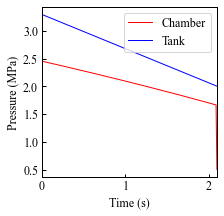

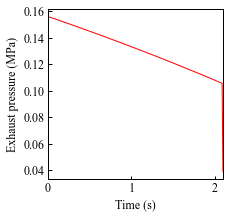

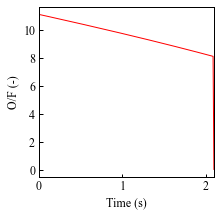

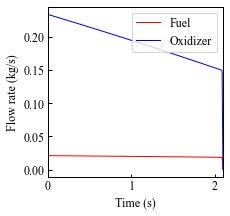

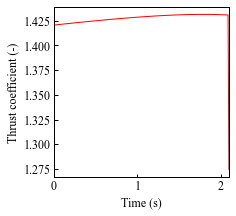

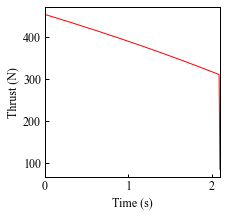

In [30]:
#! /usr/bin/env python
# coding: utf-8
 
start_time = time.perf_counter()

t_b = simulation_time
looptimes = 0

while (abs(t_b - t_b_d) > Ts) and (looptimes < 10):
	# シミュレーション (1ステップ目)
	def func1(x):
		xP_c, P_c_d = x[0], x[1]
		return abs((xP_c - P_c_d) / P_c_d * 100)

	def cons1(x):
		xP_c, P_c_d = x[0], x[1]
		m_ox[0, 0] = 0
		P_t[0, 0] = (P_t_f - P_t_i) * 0 / t_b_d + P_t_i
		if P_t[0, 0] > xP_c:
			diff_P = P_t[0, 0] - xP_c
		else:
			diff_P = 1e-6
		if m_ox[0, 0] <= V_ox_i * rho_ox * 1e-6:
			m_dot_ox[0, 0] = C_d * (math.pi / 4 * (D_o * 1e-3)**2) * math.sqrt(2 * rho_ox * diff_P * 1e6)
		else:
			m_dot_ox[0, 0] = 0
		m_f[0, 0] = 0
		D_f[0, 0] = math.sqrt(4 * m_f[0, 0] / (N_port * math.pi * rho_f * L_f * 1e-3) + (D_f_i * 1e-3)**2) * 1e3
		G_ox[0, 0] = 4 * m_dot_ox[0, 0] / (N_port * math.pi *(D_f[0, 0] * 1e-3)**2)
		r_dot[0, 0] = a * G_ox[0, 0]**n * 1e3
		m_dot_f[0, 0] = L_f * 1e-3 * math.pi * D_f[0, 0] * 1e-3 * rho_f * r_dot[0, 0] * 1e-3 * N_port
		o_f[0, 0] = m_dot_ox[0, 0] / m_dot_f[0, 0]
		if np.round(o_f[0, 0], 1) <= 0.5:
			index_o_f = 0.5
		elif np.round(o_f[0, 0], 1) >= 19.5:
			index_o_f = 19.5
		else:
			index_o_f = np.round(o_f[0, 0], 1)
		if np.round(xP_c, 1) <= 0.5:
			index_P_c = 0.5
		elif np.round(xP_c, 1) >= 4.9:
			index_P_c = 4.9
		else:
			index_P_c = np.round(xP_c, 1)
		eta_c_star_c_star[0, 0] = eta_c_star * (df_c_star.at[index_o_f, str(index_P_c)] \
			+ (o_f[0, 0] - index_o_f) / 0.1 * (df_c_star.at[np.round(index_o_f + 0.1, 1), str(index_P_c)] - df_c_star.at[index_o_f, str(index_P_c)]) \
			+ (xP_c - index_P_c) / 0.1 * (df_c_star.at[index_o_f, str(np.round(index_P_c + 0.1, 1))] - df_c_star.at[index_o_f, str(index_P_c)]))
		gamma[0, 0] = df_gamma.at[index_o_f, str(index_P_c)] \
			+ (o_f[0, 0] - index_o_f) / 0.1 * (df_gamma.at[np.round(index_o_f + 0.1, 1), str(index_P_c)] - df_gamma.at[index_o_f, str(index_P_c)]) \
			+ (xP_c - index_P_c) / 0.1 * (df_gamma.at[index_o_f, str(np.round(index_P_c + 0.1, 1))] - df_gamma.at[index_o_f, str(index_P_c)])
		D_t[0, 0] = D_t_i
		P_e[0, 0] = 0.1
		v = P_c_d - (4 * eta_c_star_c_star[0, 0] * (m_dot_ox[0, 0] + m_dot_f[0, 0]) / (math.pi * D_t[0, 0]**2))
		return v

	cons = (
		{'type': 'eq', 'fun': cons1}
	)

	bounds = [[0.5, 5], [0.5, 5]]

	x_i = [0.5, 0.5]

	result = minimize(func1, x0=x_i, constraints=cons, bounds=bounds, method="SLSQP")
	P_c[0, 0] = result.x[0]

	def func2(xP_e):
		epsilon_d[0, 0] = ((2 / (gamma[0, 0] + 1))**(1 / (gamma[0, 0] - 1))) * ((P_c[0, 0] / xP_e)**(1 / gamma[0, 0])) / math.sqrt((gamma[0, 0] + 1) / (gamma[0, 0] - 1) * (1 - (xP_e / P_c[0, 0])**((gamma[0, 0] - 1) / gamma[0, 0])))
		v = abs((epsilon_d[0, 0] - (D_e**2 / D_t_i**2)) / (D_e**2 / D_t_i**2) * 100) # 目的関数
		return v

	result = minimize_scalar(func2, method='bounded', bounds=(0, 0.2))
	P_e[0, 0] = result.x
	C_f[0, 0] = math.sqrt(2 * gamma[0, 0]**2 / (gamma[0, 0] - 1) * ((2 / (gamma[0, 0] + 1))**((gamma[0, 0] + 1) / (gamma[0, 0] - 1))) * (1 - (P_e[0, 0] / P_c[0, 0])**((gamma[0, 0] - 1) / gamma[0, 0]))) \
		+ ((P_e[0, 0] - P_o) / P_c[0, 0]) * ((D_e**2) / D_t_i**2)
	F_t[0, 0] = ((1 + math.cos(math.radians(alpha))) / 2) * C_f[0, 0] * P_c[0, 0] * (math.pi * D_t_i**2 / 4)
	I_t[0, 0] = 0

	# シミュレーション (2ステップ目)
	def func1(x):
		xP_c, P_c_d = x[0], x[1]
		return abs((xP_c - P_c_d) / P_c_d * 100)

	def cons1(x):
		xP_c, P_c_d = x[0], x[1]
		m_ox[1, 0] = m_ox[0, 0] + m_dot_ox[0, 0] * Ts/2
		P_t[1, 0] = (P_t_f - P_t_i) * Ts / t_b_d + P_t_i
		if P_t[1, 0] > xP_c:
			diff_P = P_t[1, 0] - xP_c
		else:
			diff_P = 1e-6
		if m_ox[1, 0] <= V_ox_i * rho_ox * 1e-6:
			m_dot_ox[1, 0] = C_d * (math.pi / 4 * (D_o * 1e-3)**2) * math.sqrt(2 * rho_ox * diff_P * 1e6)
		else:
			m_dot_ox[1, 0] = 0
		m_f[1, 0] = m_f[0, 0] + m_dot_f[0, 0] * Ts/2
		D_f[1, 0] = math.sqrt(4 * m_f[1, 0] / (N_port * math.pi * rho_f * L_f * 1e-3) + (D_f_i * 1e-3)**2) * 1e3
		G_ox[1, 0] = 4 * m_dot_ox[1, 0] / (N_port * math.pi *(D_f[1, 0] * 1e-3)**2)
		r_dot[1, 0] = a * G_ox[1, 0]**n * 1e3
		m_dot_f[1, 0] = L_f * 1e-3 * math.pi * D_f[1, 0] * 1e-3 * rho_f * r_dot[1, 0] * 1e-3 * N_port
		o_f[1, 0] = m_dot_ox[1, 0] / m_dot_f[1, 0]
		if np.round(o_f[1, 0], 1) <= 0.5:
			index_o_f = 0.5
		elif np.round(o_f[1, 0], 1) >= 19.5:
			index_o_f = 19.5
		else:
			index_o_f = np.round(o_f[1, 0], 1)
		if np.round(xP_c, 1) <= 0.5:
			index_P_c = 0.5
		elif np.round(xP_c, 1) >= 4.9:
			index_P_c = 4.9
		else:
			index_P_c = np.round(xP_c, 1)
		eta_c_star_c_star[1, 0] = eta_c_star * (df_c_star.at[index_o_f, str(index_P_c)] \
			+ (o_f[1, 0] - index_o_f) / 0.1 * (df_c_star.at[np.round(index_o_f + 0.1, 1), str(index_P_c)] - df_c_star.at[index_o_f, str(index_P_c)]) \
			+ (xP_c - index_P_c) / 0.1 * (df_c_star.at[index_o_f, str(np.round(index_P_c + 0.1, 1))] - df_c_star.at[index_o_f, str(index_P_c)]))
		gamma[1, 0] = df_gamma.at[index_o_f, str(index_P_c)] \
			+ (o_f[1, 0] - index_o_f) / 0.1 * (df_gamma.at[np.round(index_o_f + 0.1, 1), str(index_P_c)] - df_gamma.at[index_o_f, str(index_P_c)]) \
			+ (xP_c - index_P_c) / 0.1 * (df_gamma.at[index_o_f, str(np.round(index_P_c + 0.1, 1))] - df_gamma.at[index_o_f, str(index_P_c)])
		D_t[1, 0] = D_t[0, 0] - r_dot_n * Ts
		P_e[1, 0] = 0.1
		v = P_c_d - (4 * eta_c_star_c_star[1, 0] * (m_dot_ox[1, 0] + m_dot_f[1, 0]) / (math.pi * D_t[1, 0]**2))
		return v

	cons = (
		{'type': 'eq', 'fun': cons1}
	)

	bounds = [[0.5, 5], [0.5, 5]]

	x_i = [0.5, 0.5]

	result = minimize(func1, x0=x_i, constraints=cons, bounds=bounds, method="SLSQP")
	P_c[1, 0] = result.x[0]

	def func2(xP_e):
		epsilon_d[1, 0] = ((2 / (gamma[1, 0] + 1))**(1 / (gamma[1, 0] - 1))) * ((P_c[1, 0] / xP_e)**(1 / gamma[1, 0])) / math.sqrt((gamma[1, 0] + 1) / (gamma[1, 0] - 1) * (1 - (xP_e / P_c[1, 0])**((gamma[1, 0] - 1) / gamma[1, 0])))
		v = abs((epsilon_d[1, 0] - (D_e**2 / D_t_i**2)) / (D_e**2 / D_t_i**2) * 100) # 目的関数
		return v

	result = minimize_scalar(func2, method='bounded', bounds=(0, 0.2))
	P_e[1, 0] = result.x
	C_f[1, 0] = math.sqrt(2 * gamma[1, 0]**2 / (gamma[1, 0] - 1) * ((2 / (gamma[1, 0] + 1))**((gamma[1, 0] + 1) / (gamma[1, 0] - 1))) * (1 - (P_e[1, 0] / P_c[1, 0])**((gamma[1, 0] - 1) / gamma[1, 0]))) \
		+ ((P_e[1, 0] - P_o) / P_c[1, 0]) * ((D_e**2) / (D_t_i**2))
	F_t[1, 0] = ((1 + math.cos(math.radians(alpha))) / 2) * C_f[1, 0] * P_c[1, 0] * (math.pi * D_t_i**2 / 4)
	I_t[1, 0] = I_t[0, 0] + (F_t[0, 0] + F_t[1, 0]) * Ts/2

	# # # シミュレーション (3ステップ目以降)
	for k in range(2, len(t)):
		def func1(x):
			xP_c, P_c_d = x[0], x[1]
			return abs((xP_c - P_c_d) / P_c_d * 100)

		def cons1(x):
			xP_c, P_c_d = x[0], x[1]
			m_ox[k, 0] = m_ox[k-1, 0] + (m_dot_ox[k-1, 0] + m_dot_ox[k-2, 0]) * Ts/2
			P_t[k, 0] = (P_t_f - P_t_i) * Ts*k / t_b_d + P_t_i
			if P_t[k, 0] > xP_c:
				diff_P = P_t[k, 0] - xP_c
			else:
				diff_P = 1e-12
			if m_ox[k, 0] <= V_ox_i * rho_ox * 1e-6:
				m_dot_ox[k, 0] = C_d * (math.pi / 4 * (D_o * 1e-3)**2) * math.sqrt(2 * rho_ox * diff_P * 1e6)
			else:
				m_dot_ox[k, 0] = 1e-12
			m_f[k, 0] = m_f[k-1, 0] + (m_dot_f[k-1, 0] + m_dot_f[k-2, 0]) * Ts/2
			D_f[k, 0] = math.sqrt(4 * m_f[k, 0] / (N_port * math.pi * rho_f * L_f * 1e-3) + (D_f_i * 1e-3)**2) * 1e3
			G_ox[k, 0] = 4 * m_dot_ox[k, 0] / (N_port * math.pi *(D_f[k, 0] * 1e-3)**2)
			r_dot[k, 0] = a * G_ox[k, 0]**n * 1e3
			m_dot_f[k, 0] = L_f * 1e-3 * math.pi * D_f[k, 0] * 1e-3 * rho_f * r_dot[k, 0] * 1e-3 * N_port
			o_f[k, 0] = m_dot_ox[k, 0] / m_dot_f[k, 0]
			if np.round(o_f[k, 0], 1) <= 0.5:
				index_o_f = 0.5
			elif np.round(o_f[k, 0], 1) >= 19.5:
				index_o_f = 19.5
			else:
				index_o_f = np.round(o_f[k, 0], 1)
			if np.round(xP_c, 1) <= 0.5:
				index_P_c = 0.5
			elif np.round(xP_c, 1) >= 4.9:
				index_P_c = 4.9
			else:
				index_P_c = np.round(xP_c, 1)
			eta_c_star_c_star[k, 0] = eta_c_star * (df_c_star.at[index_o_f, str(index_P_c)] \
				+ (o_f[k, 0] - index_o_f) / 0.1 * (df_c_star.at[np.round(index_o_f + 0.1, 1), str(index_P_c)] - df_c_star.at[index_o_f, str(index_P_c)]) \
				+ (xP_c - index_P_c) / 0.1 * (df_c_star.at[index_o_f, str(np.round(index_P_c + 0.1, 1))] - df_c_star.at[index_o_f, str(index_P_c)]))
			gamma[k, 0] = df_gamma.at[index_o_f, str(index_P_c)] \
				+ (o_f[k, 0] - index_o_f) / 0.1 * (df_gamma.at[np.round(index_o_f + 0.1, 1), str(index_P_c)] - df_gamma.at[index_o_f, str(index_P_c)]) \
				+ (xP_c - index_P_c) / 0.1 * (df_gamma.at[index_o_f, str(np.round(index_P_c + 0.1, 1))] - df_gamma.at[index_o_f, str(index_P_c)])
			D_t[k, 0] = D_t[k-1, 0] - r_dot_n * Ts
			P_e[k, 0] = 0.1
			v = P_c_d - (4 * eta_c_star_c_star[k, 0] * (m_dot_ox[k, 0] + m_dot_f[k, 0]) / (math.pi * D_t[k, 0]**2))
			return v

		cons = (
			{'type': 'eq', 'fun': cons1}
		)

		bounds = [[0.5, 5], [0.5, 5]]

		x_i = [0.5, 0.5]

		result = minimize(func1, x0=x_i, constraints=cons, bounds = bounds, method="SLSQP")
		P_c[k, 0] = result.x[0]

		def func2(xP_e):
			epsilon_d[k, 0] = ((2 / (gamma[k, 0] + 1))**(1 / (gamma[k, 0] - 1))) * ((P_c[k, 0] / xP_e)**(1 / gamma[k, 0])) / math.sqrt((gamma[k, 0] + 1) / (gamma[k, 0] - 1) * (1 - (xP_e / P_c[k, 0])**((gamma[k, 0] - 1) / gamma[k, 0])))
			v = abs((epsilon_d[k, 0] - (D_e**2 / D_t_i**2)) / (D_e**2 / D_t_i**2) * 100) # 目的関数
			return v

		result = minimize_scalar(func2, method='bounded', bounds=(0, 0.2))
		P_e[k, 0] = result.x
		C_f[k, 0] = math.sqrt(2 * gamma[k, 0]**2 / (gamma[k, 0] - 1) * ((2 / (gamma[k, 0] + 1))**((gamma[k, 0] + 1) / (gamma[k, 0] - 1))) * (1 - (P_e[k, 0] / P_c[0, 0])**((gamma[k, 0] - 1) / gamma[k, 0]))) \
			+ ((P_e[k, 0] - P_o) / P_c[k, 0]) * ((D_e**2) / D_t_i**2)
		F_t[k, 0] = ((1 + math.cos(math.radians(alpha))) / 2) * C_f[k, 0] * P_c[k, 0] * (math.pi * D_t_i**2 / 4)
		I_t[k, 0] = I_t[k-1, 0] + (F_t[k-1, 0] + F_t[k, 0]) * Ts/2
	index_fin = np.argmin(abs(m_ox - (V_ox_i * rho_ox * 1e-6)))
	t_b = t[index_fin]
	t_b_d = t_b
	for k in range(2, len(t)):
		result = minimize(func1, x0=x_i, constraints=cons, bounds = bounds, method="SLSQP")
		P_c[k, 0] = result.x[0]
		result = minimize_scalar(func2, method='bounded', bounds=(0, 0.2))
		P_e[k, 0] = result.x
		C_f[k, 0] = math.sqrt(2 * gamma[k, 0]**2 / (gamma[k, 0] - 1) * ((2 / (gamma[k, 0] + 1))**((gamma[k, 0] + 1) / (gamma[k, 0] - 1))) * (1 - (P_e[k, 0] / P_c[0, 0])**((gamma[k, 0] - 1) / gamma[k, 0]))) \
			+ ((P_e[k, 0] - P_o) / P_c[k, 0]) * ((D_e**2) / D_t_i**2)
		F_t[k, 0] = ((1 + math.cos(math.radians(alpha))) / 2) * C_f[k, 0] * P_c[k, 0] * (math.pi * D_t_i**2 / 4)
		I_t[k, 0] = I_t[k-1, 0] + (F_t[k-1, 0] + F_t[k, 0]) * Ts/2
	index_fin = np.argmin(abs(m_ox - (V_ox_i * rho_ox * 1e-6)))
	t_b = t[index_fin]
	looptimes += 1

# 出力値
F_max = np.max(F_t)
P_cmax = np.max(P_c)
index_fin = np.argmin(abs(m_ox - (V_ox_i * rho_ox * 1e-6)))
t_b = t[index_fin]
I_total = I_t[index_fin, 0]
F_ave = np.average(F_t[:index_fin])
m_ox_total = m_ox[index_fin, 0]
m_f_total = m_f[index_fin, 0]
I_sp = I_total / ((m_ox_total + m_f_total) * 9.8)
D_f_f = D_f[index_fin, 0]
Phi = (1 - (N_port * D_f_f**2 - N_port * D_f_i**2) / (D_f_out**2 - N_port * D_f_i**2)) * 100
end_time = time.perf_counter()
elapsed_time = end_time - start_time

# 結果出力
np.set_printoptions(formatter={'float': '{:.2f}'.format})
print('==================== simulation results ====================')
print(f'max thrust = {F_max} (N)')
print(f'max chamber pressure = {P_cmax} (MPa)')
print('============================================================')
print(f'burning time = {t_b} (s)')
print(f'total inpulse = {I_total} (Ns)')
print(f'average thrust = {F_ave} (N)')
print(f'oxidizer consumption = {m_ox_total} (kg)')
print(f'fuel consumption = {m_f_total} (kg)')
print(f'Isp = {I_sp} (s)')
print(f'final fuel port diameter = {D_f_f} (mm)')
print(f'sliver ratio = {Phi} (%)')
print('====================== execution time ======================')
print(f'execution time = {elapsed_time} (s)')
print(f'loop times = {looptimes} (-)')

# グラフ描画
plt.figure(figsize=(3.14,3.14))
plt.plot(t, P_c, linestyle='-', color='r', linewidth=1.0, label='Chamber')
plt.plot(t, P_t, linestyle='-', color='b', linewidth=1.0, label='Tank')
plt.xlabel('Time (s)')
plt.ylabel('Pressure (MPa)')
plt.xlim(0, t_b)
# plt.ylim(0, 6e38)
# plt.xticks(np.arange(0, 31, 5))
# plt.yticks(np.arange(0, 6e38, 1e38))
plt.legend(loc='upper right', frameon=True)
plt.savefig("./fig/pressure.pdf", dpi=300, bbox_inches='tight', pad_inches=0.05, transparent=True)

plt.figure(figsize=(3.14,3.14))
plt.plot(t, P_e, linestyle='-', color='r', linewidth=1.0, label='pe')
plt.xlabel('Time (s)')
plt.ylabel('Exhaust pressure (MPa)')
plt.xlim(0, t_b)
# plt.ylim(0, 6e38)
# plt.xticks(np.arange(0, 31, 5))
# plt.yticks(np.arange(0, 6e38, 1e38))
# plt.legend(loc='upper left', frameon=True)
plt.savefig("./fig/pe.pdf", dpi=300, bbox_inches='tight', pad_inches=0.05, transparent=True)

plt.figure(figsize=(3.14,3.14))
plt.plot(t, o_f, linestyle='-', color='r', linewidth=1.0, label='o/f')
plt.xlabel('Time (s)')
plt.ylabel('O/F (-)')
plt.xlim(0, t_b)
# plt.ylim(0, 6e38)
# plt.xticks(np.arange(0, 31, 5))
# plt.yticks(np.arange(0, 6e38, 1e38))
# plt.legend(loc='upper left', frameon=True)
plt.savefig("./fig/of.pdf", dpi=300, bbox_inches='tight', pad_inches=0.05, transparent=True)

plt.figure(figsize=(3.14,3.14))
plt.plot(t, m_dot_f, linestyle='-', color='r', linewidth=1.0, label='Fuel')
plt.plot(t, m_dot_ox, linestyle='-', color='b', linewidth=1.0, label='Oxidizer')
plt.xlabel('Time (s)')
plt.ylabel('Flow rate (kg/s)')
plt.xlim(0, t_b)
# plt.ylim(0, 6e38)
# plt.xticks(np.arange(0, 31, 5))
# plt.yticks(np.arange(0, 6e38, 1e38))
plt.legend(loc='upper right', frameon=True)
plt.savefig("./fig/mdot.pdf", dpi=300, bbox_inches='tight', pad_inches=0.05, transparent=True)

plt.figure(figsize=(3.14,3.14))
plt.plot(t, C_f, linestyle='-', color='r', linewidth=1.0, label='cf')
plt.xlabel('Time (s)')
plt.ylabel('Thrust coefficient (-)')
plt.xlim(0, t_b)
# plt.ylim(0, 6e38)
# plt.xticks(np.arange(0, 31, 5))
# plt.yticks(np.arange(0, 6e38, 1e38))
# plt.legend(loc='upper left', frameon=True)
plt.savefig("./fig/cf.pdf", dpi=300, bbox_inches='tight', pad_inches=0.05, transparent=True)

plt.figure(figsize=(3.14,3.14))
plt.plot(t, F_t, linestyle='-', color='r', linewidth=1.0, label='thrust')
plt.xlabel('Time (s)')
plt.ylabel('Thrust (N)')
plt.xlim(0, t_b)
# plt.ylim(0, 6e38)
# plt.xticks(np.arange(0, 31, 5))
# plt.yticks(np.arange(0, 6e38, 1e38))
# plt.legend(loc='upper left', frameon=True)
plt.savefig("./fig/thrust.pdf", dpi=300, bbox_inches='tight', pad_inches=0.05, transparent=True)

plt.show()